In [20]:
import pandas as pd

df = pd.read_csv("Project-Management-2.csv")
head = df.head()

#1)	Conversion des dates Start Date & End Date au format datetime.
df['Start Date'] = pd.to_datetime(df['Start Date'], dayfirst=True, errors='coerce')
df['End Date'] = pd.to_datetime(df['End Date'], dayfirst=True, errors='coerce')

#Création du colonne : Duration_days
df['Duration Days'] = (df['End Date'] - df['Start Date']).dt.days

#Création du colonne Delay
df['Delay'] = df['Project Status'].apply(lambda x: 1 if x == 'Behind' else 0)

#Création du colonne Budget Deviation
df['Budget Deviation'] = df['Budget'] - df['Actual Cost']

#Création du colonne Resource Usage Ratio
df['Resource Usage Ratio'] = df.apply(
    lambda row: row['Hours Spent'] / row['Duration Days'] if row['Duration Days'] and row['Duration Days'] > 0 else None,
    axis=1
)


head = df.head()
describe = df.describe(include='all')
missing_values = df.isnull().sum()

In [ ]:
head, describe, missing_values

(  Project ID                           Project Name Project Type  \
 0       P001     Renovation of a School Project 001   Renovation   
 1       P001     Renovation of a School Project 001   Renovation   
 2       P001     Renovation of a School Project 001   Renovation   
 3       P002  Innovation of a Classroom Project 002   Innovation   
 4       P002  Innovation of a Classroom Project 002   Innovation   
 
        Location Start Date   End Date Project Status Priority Task ID  \
 0         Texas 2024-07-21 2024-08-08         Behind   Medium    T001   
 1    New Jersey 2024-07-21 2024-08-12         Behind     High    T002   
 2          Ohio 2024-07-21 2024-08-10         Behind     High    T003   
 3  Pennsylvania 2024-06-04 2025-07-12       On Track     High    T001   
 4      New York 2024-06-04 2025-06-26       On Track   Medium    T002   
 
                                            Task Name  Task Status Assigned To  \
 0     Task 001 of Renovation of a School Project 001  I

In [ ]:
info=df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Project ID            300 non-null    object        
 1   Project Name          300 non-null    object        
 2   Project Type          300 non-null    object        
 3   Location              300 non-null    object        
 4   Start Date            300 non-null    datetime64[ns]
 5   End Date              300 non-null    datetime64[ns]
 6   Project Status        300 non-null    object        
 7   Priority              300 non-null    object        
 8   Task ID               300 non-null    object        
 9   Task Name             300 non-null    object        
 10  Task Status           300 non-null    object        
 11  Assigned To           300 non-null    object        
 12  Hours Spent           300 non-null    int64         
 13  Budget              

**Standardisation des colonnes**

In [21]:
from sklearn.preprocessing import StandardScaler

# Liste des colonnes à standardiser
cols_to_scale = ['Duration Days', 'Budget Deviation', 'Resource Usage Ratio', 'Hours Spent', 'Progress']

# Initialiser le scaler
scaler = StandardScaler()

# Appliquer le scaler
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

# Aperçu du résultat
df_scaled[cols_to_scale].head()


Duration Days  Budget Deviation  Resource Usage Ratio  Hours Spent  \
0      -1.112222          1.674955              0.199289    -0.627710   
1      -1.083521          1.146265             -0.200981    -1.324199   
2      -1.097871         -1.134970             -0.144693    -1.237138   
3       1.650215         -0.692298             -0.301917     0.417023   
4       1.535413          0.966915             -0.295618     0.591145   

   Progress  
0 -1.178343  
1 -0.226307  
2  1.082742  
3 -0.910583  
4 -0.940334

**Encodage des colonnes ( label encoding )**

In [58]:
from sklearn.preprocessing import LabelEncoder

# Créer une copie du DataFrame pour ne pas modifier l'original
df_encoded = df.copy()

# Liste des colonnes à encoder avec label encoding (ex : Priority)
cols_to_label_encode = ['Priority', 'Task Status', 'Project Status', 'Assigned To', 'Project Type', 'Location','Project Name', 'Task Name']

# Appliquer LabelEncoder sur chaque colonne
le = LabelEncoder()
for col in cols_to_label_encode:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

df_encoded[cols_to_label_encode].head()

Priority  Task Status  Project Status  Assigned To  Project Type  Location  \
0         2            1               0            1             5        10   
1         0            1               0            2             5         5   
2         0            0               0            2             5         8   
3         0            2               3            2             2         9   
4         2            2               3            2             2         6   

   Project Name  Task Name  
0            68         68  
1            68        168  
2            68        268  
3            48         48  
4            48        148

In [52]:
#download the new dataset
df.to_csv("updated_dataset.csv", index=False)

**start creating the models **

In [53]:
!pip install xgboost scikit-learn


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
X = df_encoded.drop(columns=['Delay', 'Start Date', 'End Date', 'Project ID', 'Task ID'])
y = df_encoded['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Initialize the model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)

# Print the results
print(f"Logistic Regression - Accuracy: {accuracy_logreg}")
print(f"Logistic Regression - F1 Score: {f1_logreg}")
print(f"Logistic Regression - AUC: {roc_auc_logreg}")

Logistic Regression - Accuracy: 0.8833333333333333
Logistic Regression - F1 Score: 0.72
Logistic Regression - AUC: 0.8142389525368249


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


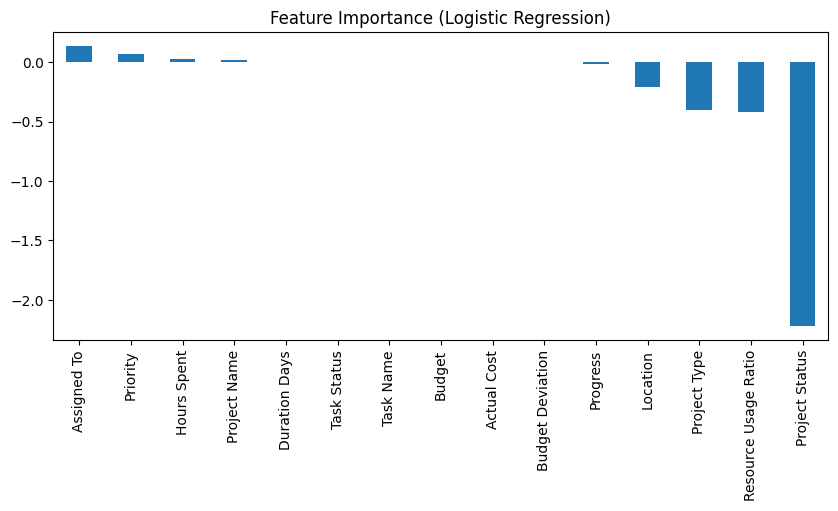

In [64]:
importance = pd.Series(logreg.coef_[0], index=X.columns)
importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title='Feature Importance (Logistic Regression)')
plt.show()


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_logreg))


              precision    recall  f1-score   support

           0       0.92      0.94      0.93        47
           1       0.75      0.69      0.72        13

    accuracy                           0.88        60
   macro avg       0.83      0.81      0.82        60
weighted avg       0.88      0.88      0.88        60

